# Cold War Simulation

In *Predicting Politics*, BDM applies the model to forecasting the course of the Cold War, starting from 1948. Here, I will try to replicate this experiment.

In [1]:
import copy
from collections import defaultdict, namedtuple, Counter
from itertools import combinations


import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from negotiation_model import *
from bdm_agent import *

## Define the agents

In [3]:
class BDMActor(NegotiationActor):
    DecisionClass = BDM_Agent

In [4]:
class NegotiationModel_(NegotiationModel):
    # Variables for median caching
    median_computed_last = -1
    median = -1
    
    def find_median(self):
        if self.median_computed_last != self.schedule.steps:
            self.median = super().find_median()
            self.median_computed_last = self.schedule.steps
        return self.median

# Using Original Data

In [5]:
book_data = pd.read_csv("BDM_ColdWar.csv")

In [6]:
book_data.head()

,Country,Capability,Position
0,Argentina,0.972,89.6
1,Australia,0.889,1.3
2,Belgium,1.182,2.8
3,Brazil,0.993,89.6
4,Bulgaria,0.345,-100.0


In [7]:
# Normalize
book_data.Position = (book_data.Position + 100)/200

In [9]:
agents = []
for i, row in book_data.iterrows():
    new_agent = BDMActor(row.Country, row.Capability, row.Position, 1)
    agents.append(new_agent)

model = NegotiationModel_(agents)

(0, 1)

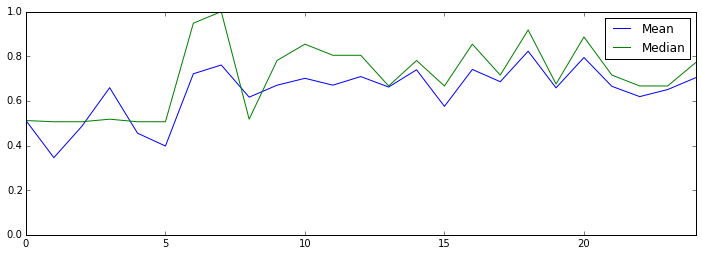

In [10]:
p_shock = 1

for i in range(25):
    for agent in model.agents:
            agent.salience = random.random()
    model.step()

df = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize=(12,4))
df.plot(ax=ax)
ax.set_ylim(0, 1)

In [ ]:
model.agent_names["USA"]

In [ ]:
usa = model.agent_names["USA"]
usa.decision_model.action_log

## Original Data Batch Run

In [11]:
agents = []
for i, row in book_data.iterrows():
    new_agent = BDMActor(row.Country, row.Capability, row.Position, 1)
    new_agent.decision_model.Q = 0.5
    new_agent.decision_model.T = 0.5
    #new_agent.decision_model.T = 1
    agents.append(new_agent)

In [ ]:
all_models = []
for i in range(100):
    model = NegotiationModel_(copy.deepcopy(agents))
    for _ in range(25):
        for agent in model.agents:
            agent.salience = random.random()
        model.step()
    all_models.append(model)

In [ ]:
all_dfs = []
for i, model in enumerate(all_models):
    df = model.datacollector.get_model_vars_dataframe()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)

In [ ]:
results = pd.concat(all_dfs)

In [ ]:
results.rename(columns={"index": "Step"}, inplace=True)

In [ ]:
results.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, group in results.groupby("Iteration"):
    group.plot(x="Step", y="Median", color='k', alpha=0.2, ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.grid(True)

In [ ]:
results[results.Step==24]["Median"].hist()

In [ ]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
plt.plot(base[:-1], cdf)

In [ ]:
m1 = all_models[1]
m14 = all_models[14]

In [ ]:
print(m1.find_median())
print(m14.find_median())

In [ ]:
m1.log.tversky_index(m14.log)

In [ ]:
m14.log.tversky_index(m1.log)

In [ ]:
m1.log.get_events(action="Attack")

### Count conflict dyads

In [ ]:
conflict_dyads = defaultdict(set)

for i, model in enumerate(all_models):
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        else:
            dyad = (source, target)
        conflict_dyads[dyad].add(i)

In [ ]:
conflict_count = Counter({k: len(v) for k, v in conflict_dyads.items()})

In [ ]:
conflict_count.most_common()

### Narrow it down to cases with a favorable US outcome

In [ ]:
conflict_dyads = defaultdict(set)

for i, model in enumerate(all_models):
    if model.find_median() < 0.75:
        continue
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        else:
            dyad = (source, target)
        conflict_dyads[dyad].add(i)

conflict_count = Counter({k: len(v) for k, v in conflict_dyads.items()})

In [ ]:
conflict_count.most_common()